# Boolean Functions as Random Variables

**Reference: O'Donnell, Chapters 1-3, 8**

When inputs to a Boolean function $f: \{-1,+1\}^n \to \{-1,+1\}$ are drawn from a probability distribution, $f$ becomes a random variable. This perspective unlocks:

1. **Monte Carlo estimation** — compute Fourier coefficients and influences without materializing truth tables
2. **Spectral sampling** — draw subsets $S$ proportional to $\hat{f}(S)^2$
3. **P-biased analysis** — change the input distribution to reveal threshold phenomena
4. **The estimation/computation tradeoff** — when exact computation is infeasible, sampling still works

### Key Formulas

- $\mathbb{E}[f] = \hat{f}(\emptyset)$ — expectation equals the empty Fourier coefficient
- $\text{Var}[f] = \sum_{S \neq \emptyset} \hat{f}(S)^2$ — Parseval's identity
- $\hat{f}(S) = \mathbb{E}_x[f(x) \chi_S(x)]$ — Fourier coefficients are expectations, hence estimable by sampling
- Spectral distribution: $\Pr[S] = \hat{f}(S)^2$ for $\pm 1$-valued $f$

In [1]:
# Setup
!pip install --upgrade boofun -q

import numpy as np
import matplotlib.pyplot as plt
import time
import boofun as bf

from boofun.analysis.sampling import (
    sample_uniform, sample_biased, sample_spectral,
    sample_input_output_pairs,
    estimate_fourier_coefficient, estimate_influence,
    estimate_total_influence,
    RandomVariableView, SpectralDistribution,
)

np.random.seed(42)
print(f"boofun version: {bf.__version__}")


[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/core/errormodels.py:21: UserWarning: uncertainties library not available - some error models disabled
  warnings.warn("uncertainties library not available - some error models disabled")


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/quantum/__init__.py:22: UserWarning: Qiskit not available - quantum features limited
  warnings.warn("Qiskit not available - quantum features limited")


boofun version: 1.1.1


## 1. Sampling Basics

BooFun provides samplers for the **uniform distribution** ($p = 1/2$) and the **$p$-biased distribution** $\mu_p$ (each bit is 1 independently with probability $p$). A quick sanity check:

In [2]:
# Verify: average Hamming weight matches expected value n*p
n = 8
for p in [0.2, 0.5, 0.8]:
    samples = sample_biased(n, p, n_samples=5000)
    avg_ones = np.mean([bin(x).count('1') for x in samples])
    print(f"p={p:.1f}: avg #ones = {avg_ones:.2f} (expected {p*n:.2f})")

p=0.2: avg #ones = 1.60 (expected 1.60)
p=0.5: avg #ones = 3.99 (expected 4.00)
p=0.8: avg #ones = 6.38 (expected 6.40)


## 2. Spectral Sampling

The **spectral distribution** of $f$ draws subsets $S$ with probability $\hat{f}(S)^2$. For $\pm 1$-valued functions, Parseval guarantees $\sum_S \hat{f}(S)^2 = 1$, making this a valid distribution.

This reveals where a function's "energy" lives in the Fourier domain — critical for learning algorithms like Goldreich-Levin and the KM junta learning algorithm.

In [3]:
# XOR concentrates all spectral weight on one subset; AND spreads it
for name, f, n in [("XOR\u2082", bf.create([0, 1, 1, 0]), 2), ("AND\u2083", bf.AND(3), 3)]:
    samples = sample_spectral(f, n_samples=1000)
    fourier = f.fourier()
    print(f"\n{name} spectral distribution:")
    unique, counts = np.unique(samples, return_counts=True)
    sampled_freq = dict(zip(unique, counts / 1000))
    for s in range(2**n):
        bits = [i for i in range(n) if (s >> i) & 1]
        set_str = "{" + ",".join(map(str, bits)) + "}" if bits else "\u2205"
        exact = fourier[s]**2
        sampled = sampled_freq.get(s, 0)
        if exact > 0.01:
            print(f"  S={set_str:>8}: f\u0302(S)\u00b2={exact:.4f}  sampled={sampled*100:.1f}%")

print("\n\u2192 XOR: all weight on the full set (degree n)")
print("\u2192 AND: weight spread across all subsets (including heavy weight on \u2205)")


XOR₂ spectral distribution:
  S=   {0,1}: f̂(S)²=1.0000  sampled=100.0%

AND₃ spectral distribution:
  S=       ∅: f̂(S)²=0.5625  sampled=55.7%
  S=     {0}: f̂(S)²=0.0625  sampled=5.1%
  S=     {1}: f̂(S)²=0.0625  sampled=7.0%
  S=   {0,1}: f̂(S)²=0.0625  sampled=5.8%
  S=     {2}: f̂(S)²=0.0625  sampled=6.7%
  S=   {0,2}: f̂(S)²=0.0625  sampled=6.8%
  S=   {1,2}: f̂(S)²=0.0625  sampled=6.5%
  S= {0,1,2}: f̂(S)²=0.0625  sampled=6.4%

→ XOR: all weight on the full set (degree n)
→ AND: weight spread across all subsets (including heavy weight on ∅)


## 3. Monte Carlo Estimation

Since $\hat{f}(S) = \mathbb{E}_x[f(x)\chi_S(x)]$, we can estimate via sampling:

$$\hat{f}(S) \approx \frac{1}{N}\sum_{i=1}^{N} f(x_i)\chi_S(x_i)$$

Error scales as $O(1/\sqrt{N})$ by the Central Limit Theorem. Similarly, influences can be estimated by sampling random inputs and checking if flipping a bit changes the output.

In [4]:
# Estimate Fourier coefficients of AND_3
f = bf.AND(3)
exact_fourier = f.fourier()

print("Monte Carlo estimation of AND\u2083 Fourier coefficients:")
header = "{:<12} {:>10} {:>10} {:>10}".format("Subset", "Exact", "Estimated", "Error")
print(header)
print("-" * 45)
for s in range(8):
    bits = [i for i in range(3) if (s >> i) & 1]
    set_str = "{" + ",".join(map(str, bits)) + "}" if bits else "\u2205"
    exact = exact_fourier[s]
    est = estimate_fourier_coefficient(f, s, n_samples=10000)
    print(f"{set_str:<12} {exact:>10.4f} {est:>10.4f} {abs(exact-est):>10.4f}")

Monte Carlo estimation of AND₃ Fourier coefficients:
Subset            Exact  Estimated      Error
---------------------------------------------
∅                0.7500     0.7522     0.0022
{0}              0.2500     0.2482     0.0018
{1}              0.2500     0.2594     0.0094
{0,1}           -0.2500    -0.2486     0.0014


{2}              0.2500     0.2368     0.0132
{0,2}           -0.2500    -0.2568     0.0068
{1,2}           -0.2500    -0.2584     0.0084


{0,1,2}          0.2500     0.2562     0.0062


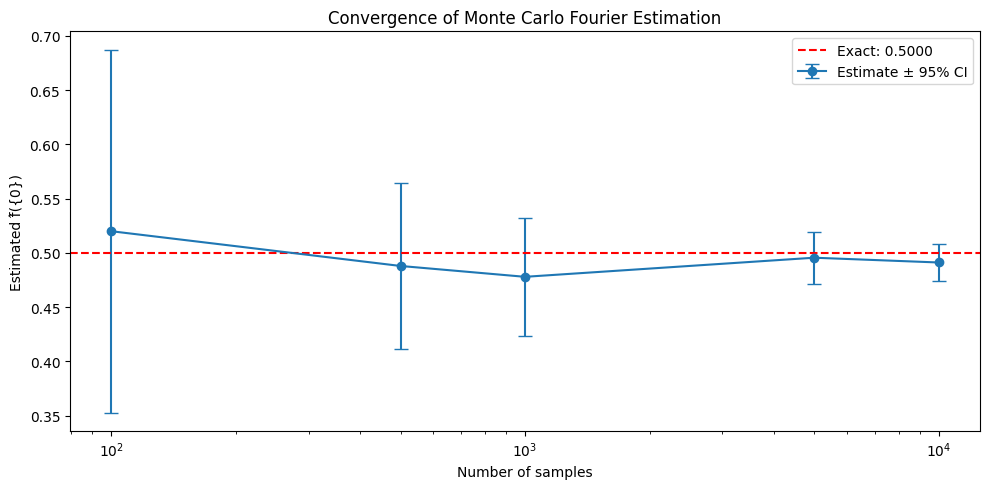

As N → ∞, estimate → exact value 0.5000
Error scales as O(1/√N) by the Central Limit Theorem


In [5]:
# Convergence: confidence intervals shrink as O(1/sqrt(N))
f = bf.majority(3)
S = 1  # Coefficient on {0}
exact = f.fourier()[S]

sample_sizes = [100, 500, 1000, 5000, 10000]
estimates, ci_widths = [], []
for ns in sample_sizes:
    est, std_err = estimate_fourier_coefficient(f, S, n_samples=ns, return_confidence=True)
    estimates.append(est)
    ci_widths.append(1.96 * std_err)

plt.figure(figsize=(10, 5))
plt.errorbar(sample_sizes, estimates, yerr=ci_widths, fmt='o-', capsize=5,
             label='Estimate \u00b1 95% CI')
plt.axhline(y=exact, color='red', linestyle='--', label=f'Exact: {exact:.4f}')
plt.xlabel('Number of samples')
plt.ylabel('Estimated f\u0302({0})')
plt.title('Convergence of Monte Carlo Fourier Estimation')
plt.legend()
plt.xscale('log')
plt.tight_layout()
plt.show()

print(f"As N \u2192 \u221e, estimate \u2192 exact value {exact:.4f}")
print("Error scales as O(1/\u221aN) by the Central Limit Theorem")

## 4. When to Estimate vs Compute Exactly

The exact Fourier transform enumerates all $2^n$ inputs. For small $n$ this is instant; for large $n$ it becomes infeasible.

| $n$ | Truth table size | Exact | Monte Carlo (10K samples) |
|-----|-----------------|-------|---------------------------|
| $\leq 14$ | $\leq$ 16K | Fast (ms) | Unnecessary |
| $14$–$20$ | 16K–1M | Feasible (s) | Faster alternative |
| $> 20$ | $> 1$M | **Infeasible** | **Only option** |

This is the fundamental value of the probabilistic view: **sampling scales to any $n$**, as long as you have oracle access to $f$.

In [6]:
# Small n: exact is instant
f_small = bf.majority(5)
t0 = time.time()
exact_val = f_small.fourier()[1]
exact_ms = (time.time() - t0) * 1000

t0 = time.time()
est_val = estimate_fourier_coefficient(f_small, 1, n_samples=10000)
est_ms = (time.time() - t0) * 1000

print(f"n=5:  Exact f\u0302({{0}}) = {exact_val:.6f}  ({exact_ms:.1f}ms)")
print(f"      Est.  f\u0302({{0}}) = {est_val:.6f}  ({est_ms:.1f}ms)  error={abs(exact_val-est_val):.6f}")
print()

# Large n: oracle-based estimation still works
n_large = 20
f_large = bf.create(lambda x: 1 if sum(x) > n_large // 2 else 0, n=n_large)

t0 = time.time()
est_large, se = estimate_fourier_coefficient(f_large, 1, n_samples=10000, return_confidence=True)
est_ms_large = (time.time() - t0) * 1000

print(f"n={n_large}: Oracle-based estimation via 10K samples ({est_ms_large:.1f}ms)")
print(f"      Est.  f\u0302({{0}}) = {est_large:.6f} \u00b1 {1.96*se:.6f}")
print(f"      (Exact would require enumerating {2**n_large:,} inputs)")

n=5:  Exact f̂({0}) = 0.375000  (0.5ms)
      Est.  f̂({0}) = 0.369600  (48.1ms)  error=0.005400

n=20: Oracle-based estimation via 10K samples (29.9ms)
      Est.  f̂({0}) = 0.190800 ± 0.019240
      (Exact would require enumerating 1,048,576 inputs)


## 5. The RandomVariableView

The `RandomVariableView` class wraps a Boolean function with both exact and Monte Carlo methods, providing a unified interface for probabilistic analysis.

In [7]:
# Full summary of a function as a random variable
f = bf.tribes(2, 6)  # tribes of size 2 on 6 variables (3 tribes)
rv = RandomVariableView(f)
print(rv.summary())

RandomVariableView (n=6, p=0.5)
  E[f] = 0.156250
  Var[f] = 0.975586
  I[f] = 1.687500
  Spectral entropy = 4.6210 bits
  Effective support = 10 subsets

  Weight by degree:
    W^0[f] = 0.024414
    W^1[f] = 0.474609
    W^2[f] = 0.342773
    W^3[f] = 0.113281
    W^4[f] = 0.038086
    W^5[f] = 0.005859
    ...


In [8]:
# Cross-validate exact vs estimated values
f = bf.majority(5)
rv = RandomVariableView(f).seed(42)

print("Exact vs Estimated (10,000 samples):")
print(f"  E[f]:  exact={rv.expectation():.4f},  est={rv.estimate_expectation(10000):.4f}")
print(f"  Var[f]: exact={rv.variance():.4f},  est={rv.estimate_variance(10000):.4f}")
print(f"  I[f]:  exact={rv.total_influence():.4f},  est={rv.estimate_total_influence(10000):.4f}")
print()

results = rv.validate_estimates(n_samples=10000, tolerance=0.1)
print("Validation (tolerance = 10%):")
check, cross = "\u2713", "\u2717"
for metric, passed in results.items():
    status = check if passed else cross
    print(f"  {metric}: {status}")

Exact vs Estimated (10,000 samples):
  E[f]:  exact=0.0000,  est=0.0126
  Var[f]: exact=1.0000,  est=0.9999


  I[f]:  exact=1.8750,  est=1.8933



Validation (tolerance = 10%):
  expectation: ✓
  variance: ✓
  total_influence: ✓
  fourier_empty: ✓


## 6. P-Biased Measures and Threshold Phenomena

Under the **$p$-biased distribution** $\mu_p$, each bit is 1 independently with probability $p$. This generalizes the uniform case ($p = 1/2$) and reveals deep structure:

- **Threshold phenomena**: monotone functions exhibit sharp phase transitions at a critical $p_c$
- **Russo's formula**: the slope of the threshold curve equals the total influence
- **Connections to complexity**: sharp thresholds connect to Friedgut's junta theorem and hardness of approximation

Reference: O'Donnell, Chapter 8.4.

In [9]:
from boofun.analysis.p_biased import (
    p_biased_expectation as exact_p_biased_expectation,
    p_biased_total_influence as exact_p_biased_total_influence,
    PBiasedAnalyzer,
)

# P-biased statistics for AND_3 (exact computation)
f = bf.AND(3)
print("AND\u2083 under p-biased measures:")
header = "{:<6} {:<14} {:<16} {:<10}".format("p", "E_p[f] (\u00b11)", "\u03bc_p = Pr[f=1]", "I_p[f]")
print(header)
print("-" * 48)
for p in [0.1, 0.3, 0.5, 0.7, 0.9]:
    exp = exact_p_biased_expectation(f, p)  # in \u00b11 convention
    mu_p = (1 - exp) / 2  # convert to Pr[f=1]
    inf = exact_p_biased_total_influence(f, p)
    print(f"{p:<6.1f} {exp:<14.4f} {mu_p:<16.4f} {inf:<10.4f}")

print("\n\u2192 As p \u2192 1 (more 1s), Pr[AND=1] = p\u00b3 \u2192 1")
print("\u2192 Total influence peaks near the \"interesting\" region of the threshold")

AND₃ under p-biased measures:
p      E_p[f] (±1)    μ_p = Pr[f=1]    I_p[f]    
------------------------------------------------
0.1    0.9980         0.0010           0.0300    
0.3    0.9460         0.0270           0.2700    
0.5    0.7500         0.1250           0.7500    
0.7    0.3140         0.3430           1.4700    
0.9    -0.4580        0.7290           2.4300    

→ As p → 1 (more 1s), Pr[AND=1] = p³ → 1
→ Total influence peaks near the "interesting" region of the threshold


### Threshold Curves

The **threshold curve** $\mu_p(f) = \Pr_{\mu_p}[f(x) = 1]$ shows how the probability of satisfying $f$ changes with the bias. Monotone functions with high total influence exhibit **sharp thresholds** — a small change in $p$ causes a dramatic phase transition.

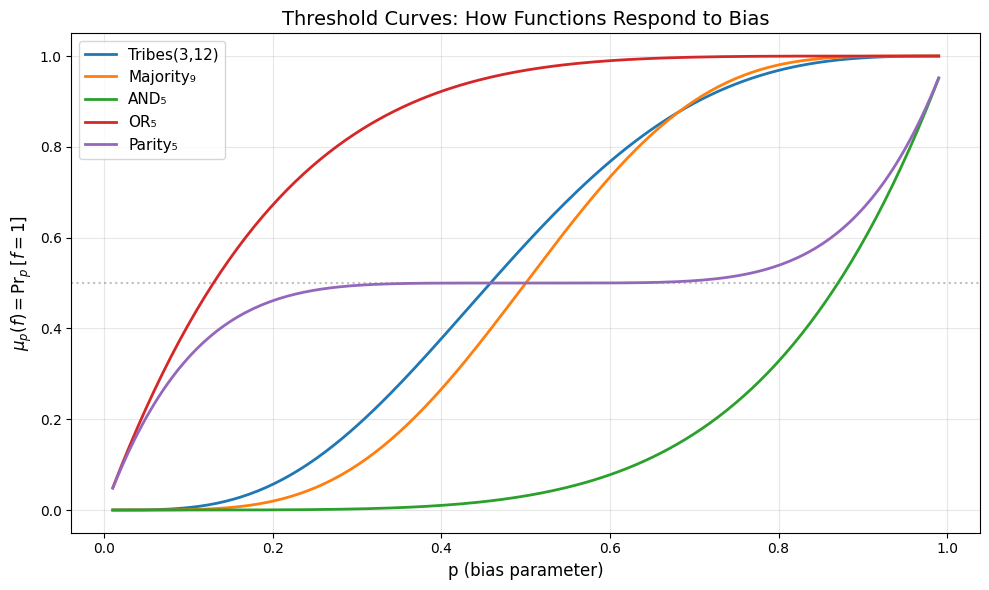

Tribes(3,12): steep S-curve — the function has many variables with balanced influence.
Majority: moderate S-curve — symmetric, centered at p = 0.5.
AND/OR: gradual curves — Pr_p[AND=1] = p⁵, each variable is pivotal only when all others are 1.
Parity: smooth curve — non-monotone, Russo's formula does not apply.

The steepness at the threshold is governed by the total influence (Russo's formula).


In [ ]:
# Threshold curves: sharp vs gradual transitions
# Note: bf.tribes(k, n) creates AND-of-ORs with tribe size k on n total variables
p_values = np.linspace(0.01, 0.99, 200)

functions = {
    "Tribes(3,12)": bf.tribes(3, 12),   # 4 tribes of 3, 12 vars
    "Majority\u2089": bf.majority(9),
    "AND\u2085": bf.AND(5),
    "OR\u2085": bf.OR(5),
    "Parity\u2085": bf.parity(5),
}

plt.figure(figsize=(10, 6))
for name, f in functions.items():
    mu_p = [(1 - exact_p_biased_expectation(f, p)) / 2 for p in p_values]
    plt.plot(p_values, mu_p, linewidth=2, label=name)

plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
plt.xlabel('p (bias parameter)', fontsize=12)
plt.ylabel('$\\mu_p(f) = \\Pr_p[f = 1]$', fontsize=12)
plt.title('Threshold Curves: How Functions Respond to Bias', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Tribes(3,12): steep S-curve \u2014 the function has many variables with balanced influence.")
print("Majority: moderate S-curve \u2014 symmetric, centered at p = 0.5.")
print("AND/OR: gradual curves \u2014 Pr_p[AND=1] = p\u2075, each variable is pivotal only when all others are 1.")
print("Parity: smooth curve \u2014 non-monotone, Russo's formula does not apply.")
print("\nThe steepness at the threshold is governed by the total influence (Russo's formula).")

### Russo's Formula (Margulis-Russo)

For **monotone** $f$, the **Margulis-Russo formula** states:

$$\frac{d}{dp}\mu_p(f) = I_p[f]$$

The slope of the threshold curve at each $p$ equals the total $p$-biased influence.

**Consequence**: High total influence $\Leftrightarrow$ steep slope $\Leftrightarrow$ sharp threshold. This is the mechanism behind the Friedgut-Kalai sharp threshold theorem.

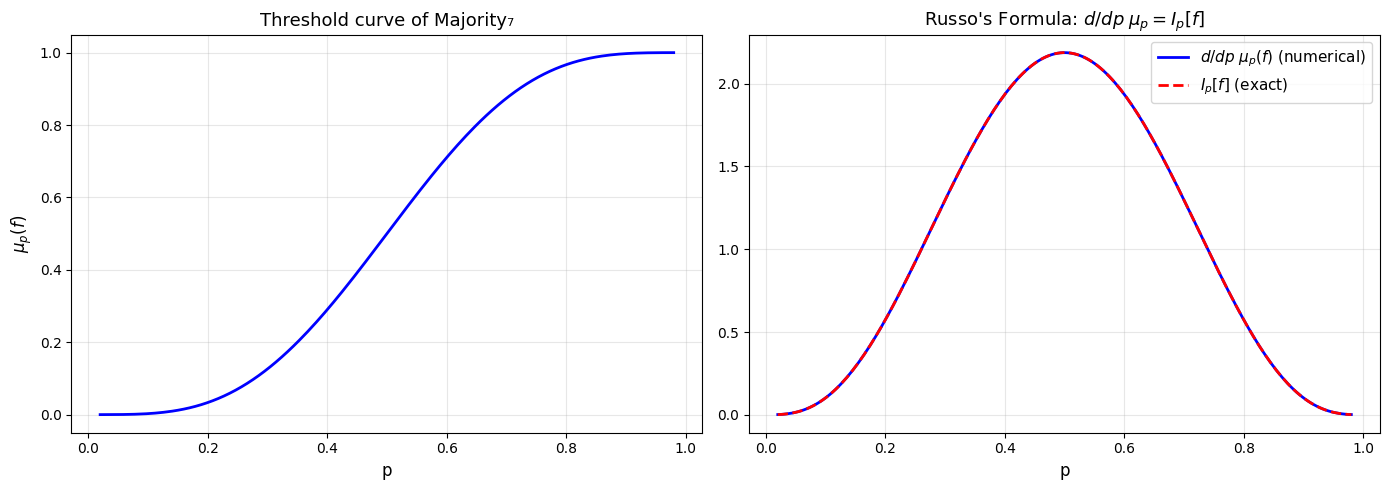

The blue and red curves overlap: the slope of the threshold curve equals
the total influence at each p. High influence = steep slope = sharp threshold.


In [11]:
# Russo's formula: d/dp mu_p(f) = I_p[f] for monotone f
f = bf.majority(7)

p_values = np.linspace(0.02, 0.98, 200)
mu_p = np.array([(1 - exact_p_biased_expectation(f, p)) / 2 for p in p_values])
total_inf = np.array([exact_p_biased_total_influence(f, p) for p in p_values])

# Numerical derivative of mu_p
dp = p_values[1] - p_values[0]
d_mu_dp = np.gradient(mu_p, dp)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: threshold curve
ax1.plot(p_values, mu_p, 'b-', linewidth=2)
ax1.set_xlabel('p', fontsize=12)
ax1.set_ylabel('$\\mu_p(f)$', fontsize=12)
ax1.set_title('Threshold curve of Majority\u2087', fontsize=13)
ax1.grid(True, alpha=0.3)

# Right: Russo's formula verification
ax2.plot(p_values, d_mu_dp, 'b-', linewidth=2, label='$d/dp\\;\\mu_p(f)$ (numerical)')
ax2.plot(p_values, total_inf, 'r--', linewidth=2, label='$I_p[f]$ (exact)')
ax2.set_xlabel('p', fontsize=12)
ax2.set_title("Russo's Formula: $d/dp\\;\\mu_p = I_p[f]$", fontsize=13)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("The blue and red curves overlap: the slope of the threshold curve equals")
print("the total influence at each p. High influence = steep slope = sharp threshold.")

### Finding the Critical Probability

The **critical probability** $p_c$ is the bias where $\mu_p(f) = 1/2$. For monotone functions, this is the "threshold" of the function — the transition point between the two phases.

In [12]:
from boofun.analysis.global_hypercontractivity import find_critical_p, threshold_curve

# Find critical p for several monotone functions
functions = {
    "Tribes(3,12)": bf.tribes(3, 12),
    "Majority\u2089": bf.majority(9),
    "AND\u2085": bf.AND(5),
    "OR\u2085": bf.OR(5),
}

print("{:<16} {:>4} {:>8} {:>12}".format("Function", "n", "p_c", "I_{p_c}[f]"))
print("-" * 44)
for name, f in functions.items():
    pc = find_critical_p(f, samples=5000)
    inf_at_pc = exact_p_biased_total_influence(f, pc)
    print(f"{name:<16} {f.n_vars:>4} {pc:>8.4f} {inf_at_pc:>12.4f}")

print("\n\u2192 AND/OR are dual: p_c(AND) = 1 - p_c(OR), and I_{p_c} is identical.")
print("\u2192 Russo's formula: d\u03bc/dp = I_p[f]. The slope AT p_c is the total influence.")
print("\u2192 Visual sharpness also depends on how the influence CONCENTRATES around p_c.")
print("   Tribes on 12 variables transitions in a narrow window; AND\u2085 = p\u2075 is gradual.")
print("\u2192 Friedgut-Kalai: monotone functions with coarse thresholds are close to juntas.")

Function            n      p_c   I_{p_c}[f]
--------------------------------------------


Tribes(3,12)       12   0.4493       2.1034


Majority₉           9   0.4961       2.4603


AND₅                5   0.8704       2.8691


OR₅                 5   0.1296       2.8691

→ AND/OR are dual: p_c(AND) = 1 - p_c(OR), and I_{p_c} is identical.
→ Russo's formula: dμ/dp = I_p[f]. The slope AT p_c is the total influence.
→ Visual sharpness also depends on how the influence CONCENTRATES around p_c.
   Tribes on 12 variables transitions in a narrow window; AND₅ = p⁵ is gradual.
→ Friedgut-Kalai: monotone functions with coarse thresholds are close to juntas.


## 7. Spectral Distribution Analysis

The `SpectralDistribution` class represents the Fourier weight distribution $\Pr[S] = \hat{f}(S)^2$. Its entropy measures how "spread out" the spectral energy is.

In [13]:
# Compare spectral structure across function families
functions = {
    "AND\u2084": bf.AND(4),
    "OR\u2084": bf.OR(4),
    "Parity\u2084": bf.parity(4),
    "Majority\u2085": bf.majority(5),
}

print("{:<15} {:<16} {:<14} {}".format("Function", "Entropy (bits)", "Eff. Support", "Degree Profile"))
print("-" * 70)
for name, f in functions.items():
    sd = SpectralDistribution.from_function(f)
    n = f.n_vars
    profile = ", ".join(
        f"W^{k}={sd.weight_at_degree(k):.3f}"
        for k in range(n + 1) if sd.weight_at_degree(k) > 0.001
    )
    print(f"{name:<15} {sd.entropy():<16.4f} {sd.effective_support_size(0.01):<14} {profile}")

print("\nParity: all weight at top degree (entropy = 0, support = 1 subset)")
print("AND/OR: weight spread evenly (high entropy, full support)")
print("Majority: weight concentrated on odd degrees (symmetric function)")

Function        Entropy (bits)   Eff. Support   Degree Profile
----------------------------------------------------------------------
AND₄            1.7012           16             W^0=0.766, W^1=0.062, W^2=0.094, W^3=0.062, W^4=0.016
OR₄             1.7012           16             W^0=0.766, W^1=0.062, W^2=0.094, W^3=0.062, W^4=0.016
Parity₄         -0.0000          1              W^4=1.000
Majority₅       3.3254           16             W^1=0.703, W^3=0.156, W^5=0.141

Parity: all weight at top degree (entropy = 0, support = 1 subset)
AND/OR: weight spread evenly (high entropy, full support)
Majority: weight concentrated on odd degrees (symmetric function)


## 8. Connection to Pseudorandomness

A Boolean function class is **foolable** by a low-randomness distribution if it cannot distinguish that distribution from truly uniform inputs. The key insight from O'Donnell Chapter 6:

> Functions with **bounded Fourier weight at high degrees** are fooled by distributions with limited independence.

Specifically, if $f$ is well-approximated by its low-degree truncation $f^{\leq d}$, then a $d$-wise independent distribution (which requires only $O(d \log n)$ random bits) "fools" $f$.

This connects to the probabilistic view: **spectral concentration** (Fourier weight concentrated at low degrees) is exactly the property that makes a function pseudorandomly foolable.

In [ ]:
from boofun.analysis.fourier import truncate_to_degree, fourier_weight_distribution

# Spectral concentration: how much weight is at low degrees?
functions = {
    "Majority\u2085": bf.majority(5),
    "Tribes(2,6)": bf.tribes(2, 6),
    "AND\u2084": bf.AND(4),
    "Parity\u2085": bf.parity(5),
}

print("Spectral concentration: fraction of Fourier weight at degree \u2264 d")
print("{:<16}".format("Function"), end="")
for d in range(5):
    print("{:>8}".format("d\u2264" + str(d)), end="")
print()
print("-" * 56)

for name, f in functions.items():
    n = f.n_vars
    weights = fourier_weight_distribution(f)
    print(f"{name:<16}", end="")
    cumulative = 0.0
    for d in range(5):
        if d < len(weights):
            cumulative += weights[d]
        print(f"{cumulative:>8.3f}", end="")
    print()

print()
print("Majority and Tribes: most weight at low degrees \u2192 foolable by O(1)-wise independence")
print("AND: significant weight at all degrees \u2192 needs higher independence")
print("Parity: ALL weight at top degree \u2192 requires full independence (hardest to fool)")
print()
print("This is why AC\u2070 circuits (constant-depth) are foolable by PRGs with few random bits:")
print("Fourier concentration results (Linial-Mansour-Nisan, H\u00e5stad-Tal) show these")
print("functions have bounded weight at high degrees.")

Spectral concentration: fraction of Fourier weight at degree ≤ d
Function             d≤0     d≤1     d≤2     d≤3     d≤4
--------------------------------------------------------
Majority₅          0.000   0.703   0.703   0.859   0.859
Tribes(2,6)        0.024   0.499   0.842   0.955   0.993
AND₄               0.766   0.828   0.922   0.984   1.000
Parity₅            0.000   0.000   0.000   0.000   0.000

Majority and Tribes: most weight at low degrees → foolable by O(1)-wise independence
AND: significant weight at all degrees → needs higher independence
Parity: ALL weight at top degree → requires full independence (hardest to fool)

This is why AC⁰ circuits (constant-depth) are foolable by PRGs with few random bits:
Fourier concentration results (Linial-Mansour-Nisan, Håstad-Tal) show these
functions have bounded weight at high degrees.


## Summary

### Key Takeaways

1. **Fourier coefficients are expectations** — $\hat{f}(S) = \mathbb{E}[f \cdot \chi_S]$ — so they can be estimated via Monte Carlo with $O(1/\sqrt{N})$ error

2. **Estimation scales to large $n$** — for $n > 20$, exact computation is infeasible but sampling-based estimation still works via oracle access

3. **P-biased measures reveal structure** — changing the input distribution from uniform to $\mu_p$ exposes threshold phenomena: sharp phase transitions governed by the total influence

4. **Russo's formula** connects the threshold slope to the total influence: $d/dp\;\mu_p(f) = I_p[f]$ for monotone $f$. High influence means sharp thresholds.

5. **Spectral concentration enables pseudorandomness** — functions with bounded Fourier weight at high degrees are "foolable" by low-randomness distributions. This is the mechanism behind PRGs for AC$^0$ (Linial-Mansour-Nisan, Hastad, Tal).

### BooFun API Reference

| Module | Key Functions |
|--------|---------------|
| `analysis.sampling` | `estimate_fourier_coefficient`, `estimate_influence`, `RandomVariableView`, `SpectralDistribution` |
| `analysis.p_biased` | `p_biased_expectation`, `p_biased_total_influence`, `PBiasedAnalyzer` |
| `analysis.global_hypercontractivity` | `threshold_curve`, `find_critical_p` |
| `analysis.fourier` | `truncate_to_degree`, `fourier_weight_distribution` |

### References

- O'Donnell, *Analysis of Boolean Functions*, Chapters 1-3 (Fourier, sampling), Chapter 6 (pseudorandomness), Chapter 8.4 (p-biased, Russo)
- Margulis (1974), Russo (1981): the Margulis-Russo formula
- Friedgut-Kalai (1996): sharp thresholds for graph properties
- Linial-Mansour-Nisan (1993): Fourier concentration for AC$^0$
- Tal (2017): tight Fourier spectrum bounds for AC$^0$

---

*This notebook demonstrates the `boofun.analysis.sampling`, `boofun.analysis.p_biased`, `boofun.analysis.fourier`, and `boofun.analysis.global_hypercontractivity` modules.*